# Sigma Sweep: Zoom into the Transition Zone

Following up on `sigma_sweep.ipynb`, which found a sharp phase transition between σ = 1e-9 (total collapse) and σ = 1e-7 (no coalescence).

Let's map the transition at higher resolution: 50 points log-spaced from 1e-9 to 1e-7.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from tqdm import tqdm

# Device detection
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

# Parameters
RANDOM_SEED = 42
N_TOKENS = 151936
N_SURVIVORS = 2200
D = 2560

# Fine sweep: 50 points from 1e-9 to 1e-7
SIGMAS = np.logspace(-9, -7, 50)

print(f"Sweeping {len(SIGMAS)} sigmas from {SIGMAS[0]:.2e} to {SIGMAS[-1]:.2e}")

Using device: mps
Sweeping 50 sigmas from 1.00e-09 to 1.00e-07


In [2]:
# Load John
DATA_DIR = Path("../../../tensors/Qwen3-4B-Instruct-2507")
W = load_file(DATA_DIR / "W_unembed.safetensors")['W'].view(torch.bfloat16)

john_bf16 = W[80091]
john_f32 = john_bf16.float()

print(f"John loaded: L2 norm = {torch.norm(john_f32).item():.6f}")

John loaded: L2 norm = 0.370917


In [3]:
def run_experiment(sigma, john_f32, n_tokens, n_survivors, d, seed):
    """Run one sigma experiment."""
    torch.manual_seed(seed)
    
    noise = torch.randn(n_tokens, d, dtype=torch.float32) * sigma
    translated = noise + john_f32.unsqueeze(0)
    quantized = translated.to(torch.bfloat16)
    
    perm = torch.randperm(n_tokens)[:n_survivors]
    survivors = quantized[perm]
    
    survivors_bits = survivors.view(torch.uint16).to(torch.int32)
    unique_bits, inverse, counts = torch.unique(
        survivors_bits, dim=0, return_inverse=True, return_counts=True
    )
    
    n_unique = len(unique_bits)
    black_hole_mask = counts > 1
    black_hole_sizes = sorted(counts[black_hole_mask].tolist(), reverse=True)
    
    return n_unique, black_hole_sizes

In [4]:
# Run the sweep
results = []

for sigma in tqdm(SIGMAS, desc="Fine sigma sweep"):
    n_unique, bh_sizes = run_experiment(
        sigma=sigma,
        john_f32=john_f32,
        n_tokens=N_TOKENS,
        n_survivors=N_SURVIVORS,
        d=D,
        seed=RANDOM_SEED
    )
    
    n_black_holes = len(bh_sizes)
    largest_bh = bh_sizes[0] if bh_sizes else 0
    tokens_in_bh = sum(bh_sizes)
    
    results.append({
        'sigma': sigma,
        'n_unique': n_unique,
        'n_black_holes': n_black_holes,
        'largest_bh': largest_bh,
        'tokens_in_bh': tokens_in_bh,
        'bh_sizes': bh_sizes
    })

print(f"\nSweep complete. {len(results)} experiments.")

Fine sigma sweep: 100%|██████████| 50/50 [02:19<00:00,  2.80s/it]


Sweep complete. 50 experiments.


In [5]:
# Extract arrays for plotting
sigmas = np.array([r['sigma'] for r in results])
n_uniques = np.array([r['n_unique'] for r in results])
n_bhs = np.array([r['n_black_holes'] for r in results])
largest_bhs = np.array([r['largest_bh'] for r in results])
tokens_in_bh = np.array([r['tokens_in_bh'] for r in results])

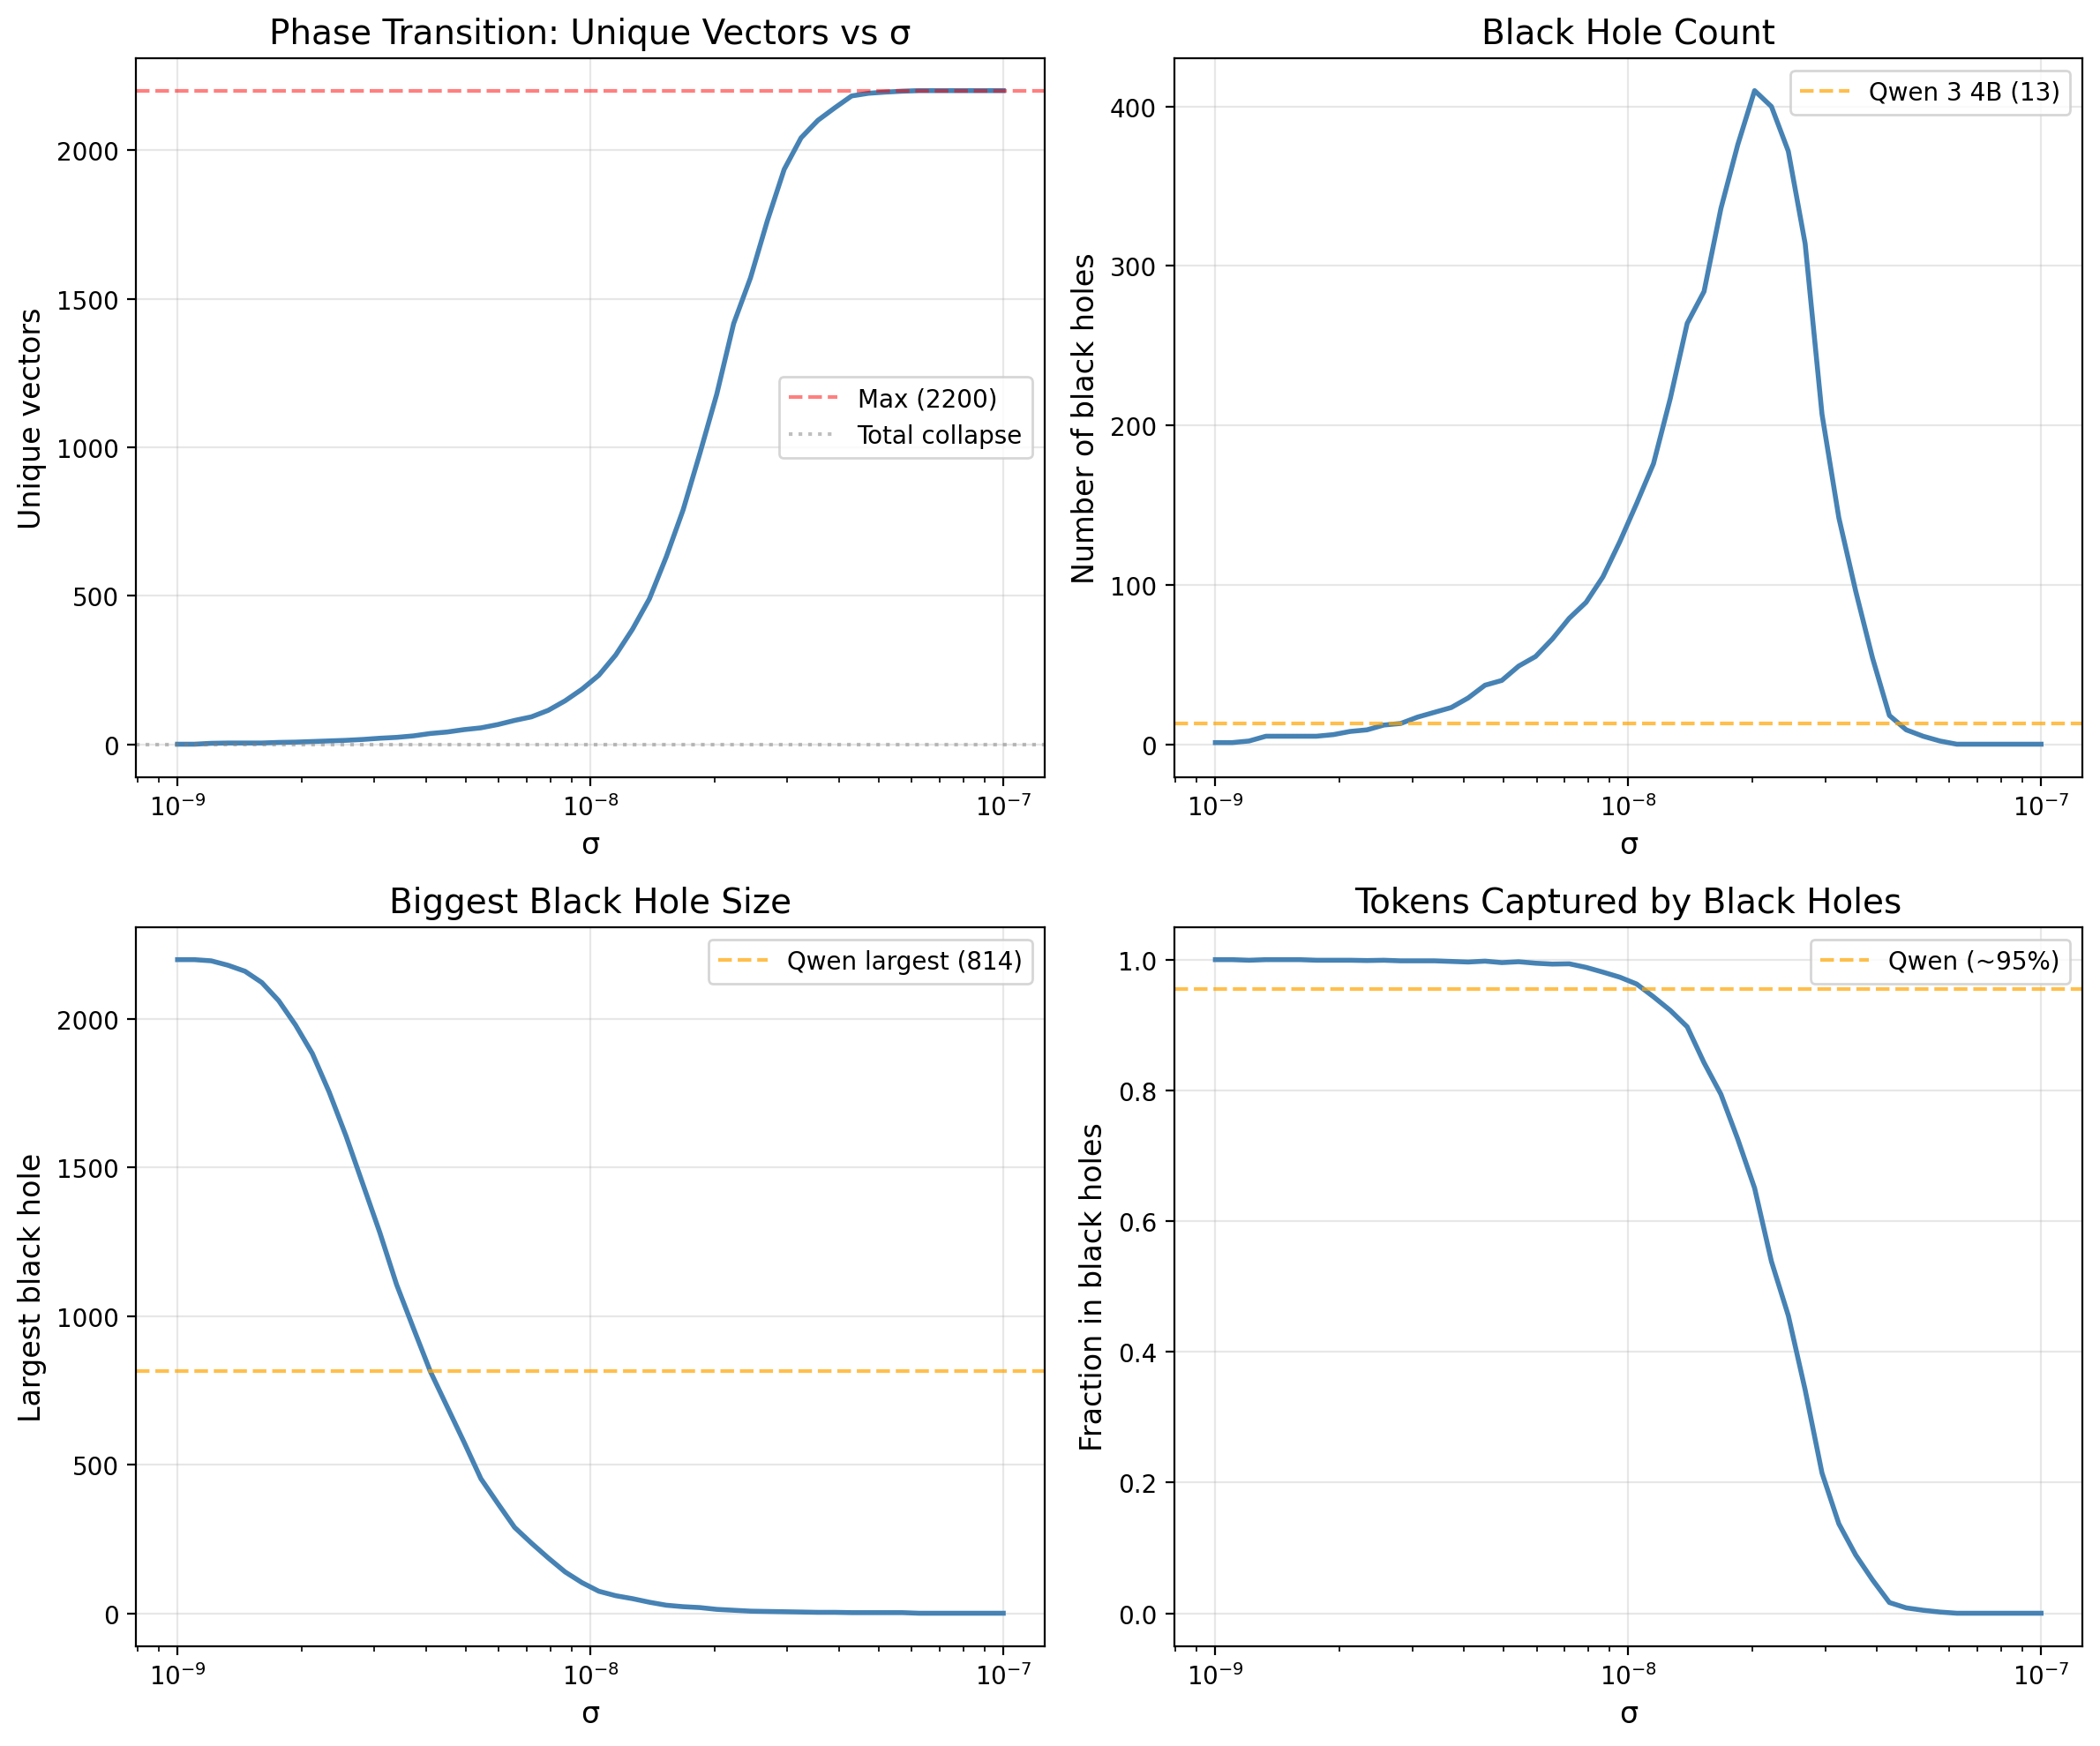

In [6]:
# Main plot: 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=200)

# Panel 1: Unique vectors (the main phase transition curve)
ax = axes[0, 0]
ax.semilogx(sigmas, n_uniques, '-', color='steelblue', linewidth=2)
ax.axhline(N_SURVIVORS, color='red', linestyle='--', alpha=0.5, label=f'Max ({N_SURVIVORS})')
ax.axhline(1, color='gray', linestyle=':', alpha=0.5, label='Total collapse')
ax.set_xlabel('σ', fontsize=12)
ax.set_ylabel('Unique vectors', fontsize=12)
ax.set_title('Phase Transition: Unique Vectors vs σ', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: Number of black holes
ax = axes[0, 1]
ax.semilogx(sigmas, n_bhs, '-', color='steelblue', linewidth=2)
ax.axhline(13, color='orange', linestyle='--', alpha=0.7, label='Qwen 3 4B (13)')
ax.set_xlabel('σ', fontsize=12)
ax.set_ylabel('Number of black holes', fontsize=12)
ax.set_title('Black Hole Count', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 3: Largest black hole
ax = axes[1, 0]
ax.semilogx(sigmas, largest_bhs, '-', color='steelblue', linewidth=2)
ax.axhline(814, color='orange', linestyle='--', alpha=0.7, label='Qwen largest (814)')
ax.set_xlabel('σ', fontsize=12)
ax.set_ylabel('Largest black hole', fontsize=12)
ax.set_title('Biggest Black Hole Size', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 4: Fraction of tokens in black holes
ax = axes[1, 1]
frac_in_bh = tokens_in_bh / N_SURVIVORS
ax.semilogx(sigmas, frac_in_bh, '-', color='steelblue', linewidth=2)
qwen_frac = 2100 / 2200  # ~95% of Qwen dead tokens are in black holes
ax.axhline(qwen_frac, color='orange', linestyle='--', alpha=0.7, label=f'Qwen (~{qwen_frac:.0%})')
ax.set_xlabel('σ', fontsize=12)
ax.set_ylabel('Fraction in black holes', fontsize=12)
ax.set_title('Tokens Captured by Black Holes', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# Find the critical sigma (where n_unique crosses 50% of max)
half_max = N_SURVIVORS / 2
crossing_idx = np.argmin(np.abs(n_uniques - half_max))
sigma_crit = sigmas[crossing_idx]

print(f"Critical sigma (50% unique): {sigma_crit:.3e}")
print(f"At σ = {sigma_crit:.3e}: {n_uniques[crossing_idx]} unique, {n_bhs[crossing_idx]} black holes")

# Find sigma where black hole count peaks
peak_bh_idx = np.argmax(n_bhs)
sigma_peak_bh = sigmas[peak_bh_idx]
print(f"\nPeak black hole count at σ = {sigma_peak_bh:.3e}: {n_bhs[peak_bh_idx]} black holes")

Critical sigma (50% unique): 2.024e-08
At σ = 2.024e-08: 1179 unique, 410 black holes

Peak black hole count at σ = 2.024e-08: 410 black holes


In [8]:
# Show black hole distributions at a few interesting sigmas
interesting_sigmas = [1e-9, sigma_crit, sigma_peak_bh, 1e-8, 5e-8, 1e-7]

print("Black hole distributions at selected σ values:")
print("=" * 70)

for target_sigma in interesting_sigmas:
    idx = np.argmin(np.abs(sigmas - target_sigma))
    r = results[idx]
    sizes = r['bh_sizes'][:8]
    sizes_str = str(sizes) if len(r['bh_sizes']) <= 8 else str(sizes)[:-1] + ', ...]'
    print(f"σ = {r['sigma']:.2e}: {r['n_unique']:4d} unique, {r['n_black_holes']:3d} BH, sizes: {sizes_str}")

print("\n" + "=" * 70)
print("Qwen 3 4B: 125 unique, 13 BH, sizes: [814, 704, 306, 228, 11, 10, 6, 5, ...]")

Black hole distributions at selected σ values:
σ = 1.00e-09:    1 unique,   1 BH, sizes: [2200]
σ = 2.02e-08: 1179 unique, 410 BH, sizes: [13, 11, 11, 10, 10, 10, 10, 9, ...]
σ = 2.02e-08: 1179 unique, 410 BH, sizes: [13, 11, 11, 10, 10, 10, 10, 9, ...]
σ = 9.54e-09:  186 unique, 127 BH, sizes: [103, 88, 83, 82, 79, 72, 69, 63, ...]
σ = 5.18e-08: 2195 unique,   5 BH, sizes: [2, 2, 2, 2, 2]
σ = 1.00e-07: 2200 unique,   0 BH, sizes: []

Qwen 3 4B: 125 unique, 13 BH, sizes: [814, 704, 306, 228, 11, 10, 6, 5, ...]


## Observations

The transition shape tells us about the mechanism. Is it:
- A sharp step function? (threshold behavior)
- A smooth sigmoid? (gradual transition)
- Something else? (multiple regimes?)